In [1]:
ANDRE_REFERENCE_DATA = "../../test_data/system_tests/maxquant_yeast_interactome/1_Final_run_5x_1800_files/#1/evidence.txt.maxquant_evidence_andre_benchmark.aq_reformat.tsv"

In [2]:
#create a pandas dataframe with 100 rows and 10.000 columns
import pandas as pd
import numpy as np
import time

num_samples = 1000
num_proteins = 4000
df = pd.DataFrame(np.random.default_rng().normal(loc=100,scale= 30,size=(num_proteins, num_samples)), columns=list(range(num_samples)))
#create array of random integers of size num_samples
scaling_factors = np.random.default_rng().integers(low=10, high=1000, size=num_samples)

#add scaling factors to columns
for i in range(num_samples):
    df[i] = df[i] + scaling_factors[i]

mask = np.random.choice([0, 1], size=(num_proteins, num_samples), p=[0.8, 0.2])
#apply mask to df
df = df.mask(mask == 1)
display(df)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,989.877251,NaN,289.788107,NaN,635.188582,NaN,1037.699006,NaN,NaN,501.870759,...,697.410143,873.789742,739.039545,642.241617,695.478964,431.542672,475.535344,628.892054,433.955496,NaN
1,965.471945,173.144513,276.708525,366.481992,599.742389,237.653835,1029.745368,188.874401,251.966746,476.645916,...,NaN,874.491543,NaN,671.906601,751.387381,394.536206,NaN,605.401287,461.511013,NaN
2,1028.010803,164.317849,288.430993,376.225076,626.454952,219.205909,1091.428877,198.112524,202.554544,547.822941,...,629.281551,933.069305,793.400516,608.552988,736.184263,NaN,471.988866,586.601318,NaN,1071.212726
3,1009.336185,156.744619,NaN,396.648074,620.107803,178.495019,1010.698328,201.400157,252.397752,NaN,...,NaN,875.034286,726.733557,636.340446,NaN,NaN,NaN,579.290360,519.130727,1096.425506
4,1038.542214,189.166992,276.297811,NaN,595.053103,269.124209,998.856510,224.267248,211.553107,447.283902,...,622.888041,906.726332,NaN,614.352774,708.358243,478.046856,471.958945,NaN,465.058101,1067.991776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,NaN,135.174994,280.256844,NaN,635.112761,187.674439,1002.356927,NaN,193.668255,500.114814,...,NaN,NaN,NaN,NaN,695.657044,472.412739,NaN,607.879761,NaN,1094.362952
3996,NaN,188.305705,NaN,342.508696,NaN,238.685469,1058.567377,211.061909,210.632365,525.238398,...,NaN,908.660040,749.865495,653.443661,737.415003,447.758432,487.944996,565.419650,422.074928,1021.329442
3997,1007.433748,185.757411,230.641345,383.847953,608.956773,215.914472,1045.075415,NaN,227.721173,532.410214,...,607.952221,913.331777,763.614940,NaN,686.428335,451.043758,492.057461,NaN,434.880551,1056.405903
3998,988.104212,95.430878,NaN,364.931642,NaN,244.255656,997.662995,220.178162,175.054770,565.298266,...,561.604667,NaN,NaN,604.833631,757.607284,NaN,454.862930,587.773757,472.346985,1017.140739


In [3]:
import directlfq.normalization

class NormalizationManagerSamplesOnSelectedProteinsDirectInput(directlfq.normalization.NormalizationManagerSamples):
    def __init__(self, complete_dataframe, num_samples_quadratic, selected_protein_groups):
        complete_dataframe = complete_dataframe.T #the samples to shift are in each row, therefore the df needs to be transposed
        self._selected_protein_groups = selected_protein_groups
        super().__init__(complete_dataframe, num_samples_quadratic)
        self.normalization_function = self._normalization_function
        self._run_normalization()
        self.complete_dataframe = complete_dataframe.T

    def _adapt_selected_proteins_to_protein_groups(self):
        if self._selected_proteins_file is not None:
            print('Normalizing only selected proteins')
            selected_proteins = pd.read_csv(self._selected_proteins_file, header=None, sep='\t')[0].to_list()
            protein2proteingroup_mapping = self._get_protein2proteingroup_mapping()
            existing_selected_proteins = [protein for protein in selected_proteins if protein in protein2proteingroup_mapping.keys()]
            self._selected_protein_groups = [protein2proteingroup_mapping[protein] for protein in existing_selected_proteins]

    def _get_protein2proteingroup_mapping(self):
        protein_groups = self.complete_dataframe.columns.get_level_values(0).to_list()
        protein2proteingroup_mapping = {protein : protein_group for protein_group in protein_groups for protein in protein_group.split(';')}
        return protein2proteingroup_mapping

    def _normalization_function(self, ion_dataframe):
        if self._selected_protein_groups is not None:
            ion_dataframe_selected = ion_dataframe.loc[:,self._selected_protein_groups]
        else:
            ion_dataframe_selected = ion_dataframe
        sample2shift = directlfq.normalization.get_normfacts(directlfq.normalization.drop_nas_if_possible(ion_dataframe_selected).to_numpy())
        df_c_normed = pd.DataFrame(directlfq.normalization.apply_sampleshifts(ion_dataframe.to_numpy(), sample2shift), index = ion_dataframe.index, columns = ion_dataframe.columns)
        return df_c_normed

    def _create_reference_sample(self):
        quadratic_subset_dataframe = self.complete_dataframe.loc[self._quadratic_subset_rows, self._selected_protein_groups]
        self._merged_reference_sample = quadratic_subset_dataframe.median(axis=0)

    def _shift_remaining_dataframe_to_reference_sample(self):
        linear_subset_dataframe = self.complete_dataframe.loc[self._linear_subset_rows]
        linear_shifted_dataframe = directlfq.normalization.SampleShifterLinear(linear_subset_dataframe, self._merged_reference_sample, protein_subset = self._selected_protein_groups).ion_dataframe
        self.complete_dataframe.loc[ self._linear_subset_rows, :] = linear_shifted_dataframe

    

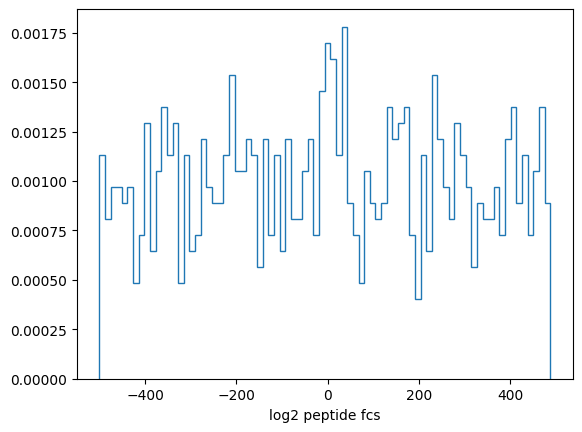

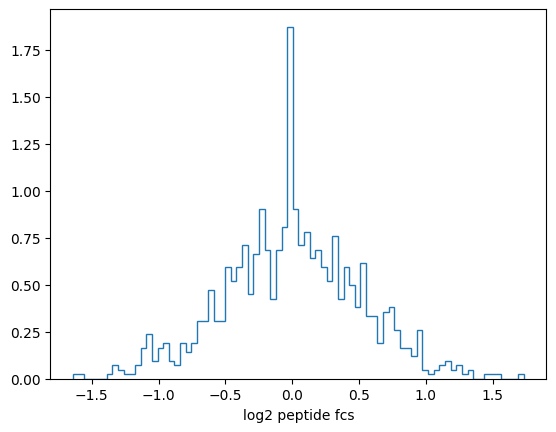

to few values for normalization without missing values. Including missing values


KeyError: '[2685, 1553, 3877, 2617, 2406, 1741, 2075, 3377, 1512, 3645, 3421, 2735, 2606, 3981, 1445, 1116, 3549, 3933, 1643, 3964, 2620, 3407, 3560, 2317, 2332, 3684, 1955, 3591, 2419, 1868, 3761, 2046, 2099, 3016, 3392, 3470, 3136, 2469, 1412, 3041, 1401, 2200, 2497, 3906, 1758, 1913, 3798, 2855, 2785, 3212, 2613, 3181, 2244, 2695, 2985, 3725, 2270, 1667, 2380, 2253, 3856, 1853, 3510, 1851, 2843, 3156, 2303, 2459, 3018, 1749, 2409, 2182, 1074] not in index'

In [4]:
import directlfq.normalization
import directlfq.visualizations as lfq_viz
import random

def visualize_normalization_steps(df_to_normalize):
    lfq_viz.plot_relative_to_median_fcs(df_to_normalize)
    input_df_normalized = directlfq.normalization.NormalizationManagerSamples(df_to_normalize.copy(), num_samples_quadratic=5).complete_dataframe
    lfq_viz.plot_relative_to_median_fcs(input_df_normalized)

    #randomly select 100 items from a list
    selected_protein_groups = random.sample(list(df_to_normalize.index), 100)
    input_df_normalized_selected_proteins = NormalizationManagerSamplesOnSelectedProteinsDirectInput(df_to_normalize.copy(), num_samples_quadratic=50, selected_protein_groups=selected_protein_groups).complete_dataframe
    lfq_viz.plot_relative_to_median_fcs(input_df_normalized_selected_proteins)
    display(input_df_normalized_selected_proteins)


visualize_normalization_steps(df)

In [5]:
import pandas as pd
df_to_normalize = pd.read_csv(ANDRE_REFERENCE_DATA, sep='\t')

/var/folders/wb/j08kzzbd2hd8838tn3ll0jfm0000gn/T/ipykernel_15891/2796637333.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_to_normalize = pd.read_csv(ANDRE_REFERENCE_DATA, sep='\t')


In [6]:
display(df_to_normalize)

,protein,ion,20190621_TIMS3_Evo4_AnMi_SA_Yeast-Interactome_0001_P01A01_YLR106C___01,20190621_TIMS3_Evo4_AnMi_SA_Yeast-Interactome_0001_P01A01_YLR106C___02,20190621_TIMS3_Evo4_AnMi_SA_Yeast-Interactome_0002_P01B01_YKR054C___01,20190621_TIMS3_Evo4_AnMi_SA_Yeast-Interactome_0002_P01B01_YKR054C___02,20190621_TIMS3_Evo4_AnMi_SA_Yeast-Interactome_0003_P01C01_YDR457W___01,20190621_TIMS3_Evo4_AnMi_SA_Yeast-Interactome_0003_P01C01_YDR457W___02,20190621_TIMS3_Evo4_AnMi_SA_Yeast-Interactome_0004_P01D01_YDR150W___01,20190621_TIMS3_Evo4_AnMi_SA_Yeast-Interactome_0004_P01D01_YDR150W___02,...,Library_15,Library_16,Library_17,Library_18,Library_19,Library_20,Library_21,Library_22,Library_23,Library_24
0,0,LRTDETLRLTGNPELSSLDEVLAKUnmodified4,2.183500e+04,0.000000e+00,1.083500e+04,0.000000e+00,1.119100e+04,0.0,9.431800e+03,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,EREWVAGMSSAGDRSSYEDSVKOxidation (M)2,2.157900e+05,1.285600e+06,2.814000e+06,9.893700e+05,0.000000e+00,824170.0,0.000000e+00,1.072000e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,EREWVAGMSSAGDRSSYEDSVKOxidation (M)3,4.839570e+06,5.484228e+06,7.682778e+06,5.322510e+06,6.022000e+06,7496200.0,9.654700e+06,6.810833e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,EREWVAGMSSAGDRSSYEDSVKOxidation (M)4,5.593080e+05,1.464768e+06,1.263365e+06,1.771694e+06,1.936322e+06,2626133.0,7.986569e+05,2.200028e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,EREWVAGMSSAGDRSSYEDSVKUnmodified2,5.464600e+06,7.028600e+06,3.913750e+06,9.563200e+06,7.482400e+06,6507950.0,5.469000e+06,4.518841e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61198,999,DLTDDINLVKUnmodified2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,...,537690.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61199,999,EMDVLMEPVRNVFGSTK2 Oxidation (M)2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,76754.0,0.0,0.0,84014.0,0.0
61200,999,MLSYPITIGSLLHKOxidation (M)2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,...,203830.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61201,999,MLSYPITIGSLLHKOxidation (M)3,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,...,306940.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
df_to_normalize = df_to_normalize.drop(columns=["protein", "ion"])
df_to_normalize = df_to_normalize.replace(0, np.nan)

In [8]:
df_to_normalize = np.log2(df_to_normalize)

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def visualize_impact_of_quadratic_sample_size_on_normalization(df_to_normalize):
    df = pd.DataFrame()
    all_cvs = []
    sample_sizes = []
    sample_list = [5, 10, 25, 50, 100, 200]
    for num_samples_quadratic in sample_list:
        cvs_sample_size = get_cvs_for_given_quadratic_sample_size(df_to_normalize, num_samples_quadratic)
        all_cvs.extend(cvs_sample_size)
        sample_sizes.extend([num_samples_quadratic] * len(cvs_sample_size))
    df_boxplot = pd.DataFrame({'CV': all_cvs, 'sample size': sample_sizes})
    return df_boxplot
    
    
    

def get_cvs_for_given_quadratic_sample_size(df_to_normalize, num_samples_quadratic):
    input_df_normalized = directlfq.normalization.NormalizationManagerSamples(df_to_normalize.copy(), num_samples_quadratic=num_samples_quadratic).complete_dataframe
    cvs = input_df_normalized.apply(cv_function, axis='columns')
    return cvs

def cv_function(x):
    x = x.to_numpy()
    if sum(~np.isnan(x)) <2:
        return np.nan
    return np.nanstd(2**x, ddof=1,) / np.nanmean(2**x)


df_boxplot = visualize_impact_of_quadratic_sample_size_on_normalization(df_to_normalize=df_to_normalize)


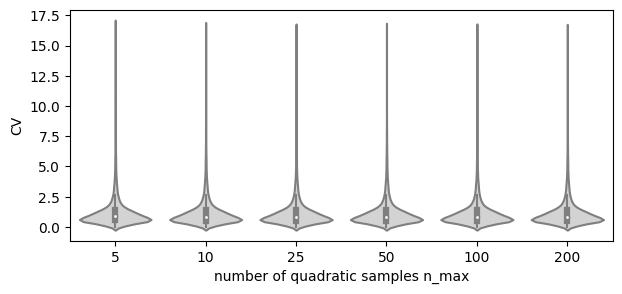

In [13]:
fig, ax = plt.subplots(figsize=(7, 3))
sns.violinplot(x="sample size", y="CV", data=df_boxplot, ax=ax, color='lightgrey')
ax.set_xlabel('number of quadratic samples n_max')

fig.savefig('quadratic_sample_size.png', dpi=300, bbox_inches='tight')
fig.savefig('quadratic_sample_size.pdf', dpi=300, bbox_inches='tight')
